# Analysis Work Flow of Nucleus Segmentation, Tracking and Visualization 

This notebook contains the workflow for tracking Cell nucelus protein binding intensities and geometries (e.g. Volume) in time-lapse movie.

Key steps of the workflows:

* Auto-Contrast intensity normalization
* 3D Gaussian smoothing 
* Masked-object Thresholding
* Watershed to remove merged objects
* Using trackpy to link frames
* Visualize segmentation and tracking results
* Plotting volume and protein binding changes as a function of time 
* Export data and statistics table



## Loading Required Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d
from scipy import ndimage as ndi
from skimage.morphology import remove_small_objects, binary_opening, ball, disk, erosion, dilation   # function for post-processing (size filter)
from aicssegmentation.core.utils import get_middle_frame
from skimage import transform, measure
import h5py
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame
import warnings
import h5py
from skimage.filters import sobel, threshold_otsu, scharr, gaussian
from skimage.segmentation import watershed
from skimage.morphology import binary_closing, ball
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops, regionprops_table
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.utils import hole_filling
import trackpy as tp
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox

## Loading Data, loading Visualization Platform and make some background functions

In [2]:
#Ignore warnings issued by skimage through conversion to uint8
warnings.simplefilter("ignore",UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)
warnings.simplefilter("ignore",FutureWarning)
# Use tkinter to interactively select files to import
root = tk.Tk()
root.withdraw()

my_filetypes = [('all files', '.*'),('Image files', '.hdf5')]

filename = filedialog.askopenfilenames(parent = root, title='Please Select a File', filetypes = my_filetypes)[0]

In [3]:
f = h5py.File(filename, 'r')

lmb1_image = f['488 Channel'][:]
cpla2_intensity_image = f['561 Channel'][:]


In [4]:
import napari
%gui qt

In [5]:
#Make a mask to clear border
from skimage.segmentation import clear_border
mask = np.ones(lmb1_image[0].shape)

for n in range(mask.shape[0]):
   im_slice = mask[n,:,:]
   im_slice[0,:] = 0
   im_slice[:,0] = 0
   im_slice[:,-1] = 0
   im_slice[-1,:] = 0

#mask[0,:,:] = 0
#mask[-1,:,:] = 0
mask = mask.astype(np.bool)


In [6]:
# Make a function to get middle frame based on segmented area
def get_middle_frame_area(labelled_image_stack):
    max_area = 0
    max_n = 0
    for z in range(labelled_image_stack.shape[0]):
       img_slice = labelled_image_stack[z,:,:]
       area = np.count_nonzero(img_slice)
       
       if area >= max_area:
          max_area = area
          max_n = z
    
    return max_n

In [7]:
def get_3dseed_from_mid_frame(bw, stack_shape, mid_frame, hole_min, bg_seed = True):
    from skimage.morphology import remove_small_objects
    out = remove_small_objects(bw>0, hole_min)
    
    out1 = label(out)
    stat = regionprops(out1)
    
    # build the seed for watershed
    seed = np.zeros(stack_shape)
    seed_count=0
    if bg_seed:
        seed[0,:,:] = 1
        seed_count += 1

    for idx in range(len(stat)):
        py, px = np.round(stat[idx].centroid)
        seed_count+=1
        seed[mid_frame,int(py),int(px)]=seed_count

    return seed

## Make the 3D Cell Segmentation Pipeline 

This segmentation pipeline has two parts. The first part is image normalization and smoothing. The second part is image segmentation

* First Part: We first apply intensity normalization and 3D Gaussian Smooth on one time point. Then we propagate to all time points. Both functions are developed by Allen Institute Segmenter. <br /> <br /> 
Link: https://github.com/AllenInstitute/aics-segmentation
<br /> <br /> 
* Second Part: We first apply Mask-Object thresholding (MO) and Watershed on one time point. In brief, MO algorithm firstly applies low threshoding (e.g. median thresholding) to roughly mask out each object. Then apply high thresholding (e.g. Ostu thresholding) within each individual object. This way it can account intensity varaiation from cell to cell. Watershed here is to seperate falsely merged object. Both algorithms are developed by Allen Segmenter. Then we propogate to all time points. 



In [8]:
# Initiate the cell segmentation class
from skimage import filters
class cell_segment:
    def __init__ (self, Time_lapse_image, sigma = 2 ):
        self.image = Time_lapse_image.copy()
        self.Time_pts = Time_lapse_image.shape[0]
        
        self.smooth_param = sigma
        
        self.bw_img = np.zeros(self.image.shape)
        self.structure_img_smooth = np.zeros(self.image.shape)
        self.segmented_object_image = np.zeros(self.image.shape, dtype = np.uint8)
        self.seed_map_list = np.zeros(self.image.shape, dtype = np.uint8)
        
        
    # define a function to apply normalization and smooth on Time lapse images
    def img_norm_smooth (self):
        for t in tqdm(range(self.Time_pts)):
            img = self.image[t].copy()
            self.structure_img_smooth[t] = ndi.median_filter(img, size=self.smooth_param)
        
   # define a function to apply Ostu Object thresholding followed by seed-based watershed to each time point
    def threshold_Time (self):
        for t in tqdm(range(self.Time_pts)):
            bw =  self.structure_img_smooth[t] > threshold_otsu(self.structure_img_smooth[t])
            
            for n in range(bw.shape[0]):
                bw[n,:,:] = binary_opening(bw[n,:,:],selem=np.ones((3,3)))
                bw[n,:,:] = hole_filling(bw[n,:,:], 1, 8000)
                bw[n,:,:] = remove_small_objects(bw[n,:,:]>0, min_size=4000, connectivity=1, in_place=False)
            
            bw = clear_border(bw, mask = mask)
            self.bw_img[t] = bw
            
            #Get middle frame 
            mid_z = get_middle_frame_area(bw)
            
            bw_mid_z = bw[mid_z,:,:]
            
            #Get seed map
            seed = get_3dseed_from_mid_frame(bw_mid_z,bw.shape, mid_z,2000, bg_seed=False)
            
            edge= scharr(self.image[t])
            seg = watershed(edge, markers=label(seed), mask=bw, watershed_line=True)
            seg = clear_border(seg, mask = mask)
            
            seg = remove_small_objects(seg>0, min_size=10000, connectivity=1, in_place=False)
            seg = hole_filling(seg, 1, 40000, fill_2d=True)
            final_seg = label(seg)

            self.segmented_object_image[t] = final_seg
            self.seed_map_list[t] = seed
        

## 3D Cell Segmentation in Timelapse

In [9]:
track = cell_segment(lmb1_image)
track.img_norm_smooth()
track.threshold_Time()



100%|██████████████████████████████████████████| 41/41 [02:17<00:00,  3.36s/it]


## Track and quantify nucleus geometry (e.g. area) and protein binding over time
<br /> 

**Cell_tracking class has two parts. The first part is to smooth intensity image, pick middle slice and segment middle plane. The second part is to track/link subsequient frame and make a table that store all information (e.g. area, protein binding, tracking ID)**

### Linking Frames in Time-Lapse Movie

* Use Trackpy to track and link consecutive frames. Remove tracks that does not meet minimum frames
* Add another **particle** column to record tracking ID

In [10]:
# Initiate the cell_tracking_quantify class

class cell_tracking_quantify:
    def __init__ (self, segmented_image_seq,seed_list,raw_image_stack, intensity_image_stack,pixel_scale= 0.29, smooth_sigma = 1.0):
        self.t = raw_image_stack.shape[0]
        self.y = raw_image_stack.shape[2]
        self.x = raw_image_stack.shape[3]
        self.labelled_stack = segmented_image_seq
        self.positions_table = None
        self.raw_image_stack = raw_image_stack
        self.raw_image_stack_2D = np.zeros((self.t,self.y,self.x))
        self.labelled_stack_2D = np.zeros((self.t,self.y,self.x))
        self.intensity_image_stack_raw = intensity_image_stack
        self.intensity_image_stack = np.zeros(intensity_image_stack.shape)
        self.intensity_image_stack_2D = np.zeros((self.t,self.y,self.x))
        self.smooth_sigma = smooth_sigma
        self.seed_map = seed_list
        self.mid_slice_stack = np.zeros(intensity_image_stack.shape)
        self.pixel_scale = pixel_scale
        self.contour_image = np.zeros((self.t,self.y,self.x))
        self.segmented_image_2D = np.zeros((self.t,self.y,self.x),dtype = np.uint8)
        self.distance_map_2D = np.zeros((self.t,self.y,self.x))
        self.seed_map_2D =  np.zeros((self.t,self.y,self.x))
        
    # Function to 3D gaussian smooth intesnity image stack
    def intensity_stack_smooth (self):
        for t in tqdm(range(self.intensity_image_stack.shape[0])):
          img = self.intensity_image_stack_raw[t].copy()
          self.intensity_image_stack[t] = image_smoothing_gaussian_3d(img, sigma=self.smooth_sigma)
            
    # function to create pandas table of cell attributes without tracking info
    def create_table_regions(self):

        positions = []

        for n in tqdm(range(0,self.t)):
            labeled_slice = self.labeled_stack[n]
    
            for region in measure.regionprops(labeled_slice):
                position = []

                z_pos = region.centroid[0]
                y_row = region.centroid[1]
                x_col = region.centroid[2]

                volume = region.area * (0.19*0.19*1)

                nucleus_image = labeled_slice == region.label
                mid_z = get_middle_frame_area(nucleus_image)
                
                mid_nucleus_image = nucleus_image[mid_z,:,:]
                
                segmented_image_shell= np.logical_xor(mid_nucleus_image,erosion(mid_nucleus_image, selem=disk(6)))
                 
                
                label = region.label
                intensity_single = self.intensity_image_stack[n]
                intensity_image = intensity_single[mid_z]
                intensity_median = np.median(intensity_image[segmented_image_shell==True])

                intensity_background = np.median(self.intensity_image_stack[n][int(mid_z),int(y_row),int(x_col)])

                intensity_median_ratio = intensity_median / intensity_background

                position.append(x_col)
                position.append(y_row)
                position.append(z_pos)
                position.append(int(n))
                position.append(label)


                position.append(volume)
                #position.append(surface_area_actual)
                position.append(intensity_median_ratio)

                positions.append(position)
                
                self.mid_slice_stack[n,mid_z,:,:] += segmented_image_shell
                self.mid_slice_stack[n,mid_z,int(y_row),int(x_col)] = 1
                
        self.positions_table  = DataFrame(positions, columns = ['x','y','z',"frame",'label','volume', 'median intensity ratio'])

    # function to quantify intensity, mid section area and put into table
    def quantification_table_generate (self):
        
         positions = []
         
         for n in tqdm(range(0,self.t)):
            labelled_image = self.segmented_image_2D[n]
            
            for region in regionprops(labelled_image):
                position = []
                
                #Calculate centroid and mid section area
                
                y_row = region.centroid[0]
                x_col = region.centroid[1]

                area = region.area * (self.pixel_scale **2)
                
                # Add contour image
                nucleus_image = labelled_image == region.label
                
                segmented_image_shell= np.logical_xor(erosion(nucleus_image, selem=disk(3)),erosion(nucleus_image, selem=disk(6)))
                 
                self.contour_image[n] += segmented_image_shell
                self.contour_image[n,int(y_row),int(x_col)] = 1
                
                #Calculate Intensity ratio
                intensity_image = self.intensity_image_stack_2D[n]
                
                intensity_value = np.max(intensity_image[segmented_image_shell==True])

                intensity_background = np.max(intensity_image[int(y_row),int(x_col)])

                intensity_ratio = intensity_value / intensity_background

                #Add into position list
                
                position.append(x_col)
                position.append(y_row)
                position.append(int(n))
                position.append(region.label)
                position.append(area)
                position.append(intensity_ratio)
                
                
                positions.append(position)
          
         #Convert data into table
         self.positions_table  = DataFrame(positions, columns = ['x','y',"frame",'label','area', 'intensity ratio'])
    
    # function to track subsequent frame
    def tracking(self,s_range= 15,stop=0.65,step=0.95, gap=8,pos=['x', 'y']):
        self.track_table = tp.link_df(self.positions_table, s_range,adaptive_stop = stop, adaptive_step = step, memory= gap, pos_columns =pos)

        #Filter out tracks with low number of frames
        self.track_table = tp.filter_stubs(self.track_table, self.t-6)
        
        #Extract track points for visualization
        track_df = self.track_table[['particle','frame','y','x']]
        track_df.index.names = ['Data']
        track_df.sort_values(by=['particle','frame'], inplace=True)
        self.track_points = track_df.values
     
    # function to crop out broken frame based on tracks
    def crop_track (self):
        self.contour_image_crop = self.contour_image.copy()
        self.segmented_image_2D_crop = self.segmented_image_2D.copy()
        
        tracks = np.unique(self.track_points[:,0])
        
        # loop through all tracks
        for tk in tracks:
            remain_tracks = self.track_points[self.track_points[:,0] == tk][:,1]
            
            #loop through all time
            for t in tqdm(range(0,self.t)):
                if t not in remain_tracks:
                  self.contour_image_crop[t] = self.contour_image_crop[t-1]
                  self.segmented_image_2D_crop[t] =  self.segmented_image_2D_crop[t-1]
                    
    # function to normalize binding intensity to 1st frame 
    def binding_normalize (self):
        self.track_table['normalized intensity ratio'] = self.track_table['intensity ratio']

        all_labels = self.track_table.particle.unique()

        for label in all_labels:
           self.track_table['normalized intensity ratio'][self.track_table.particle ==label] = self.track_table['normalized intensity ratio'][self.track_table.particle ==label]/self.track_table['intensity ratio'][self.track_table.particle ==label][0]




In [22]:
label_list = regionprops_table(Segment_tracker.labelled_stack[0])['label']
mid_intensity_image1 = Segment_tracker.intensity_image_stack[0,12,:,:]
mid_intensity_image1[a] = 0

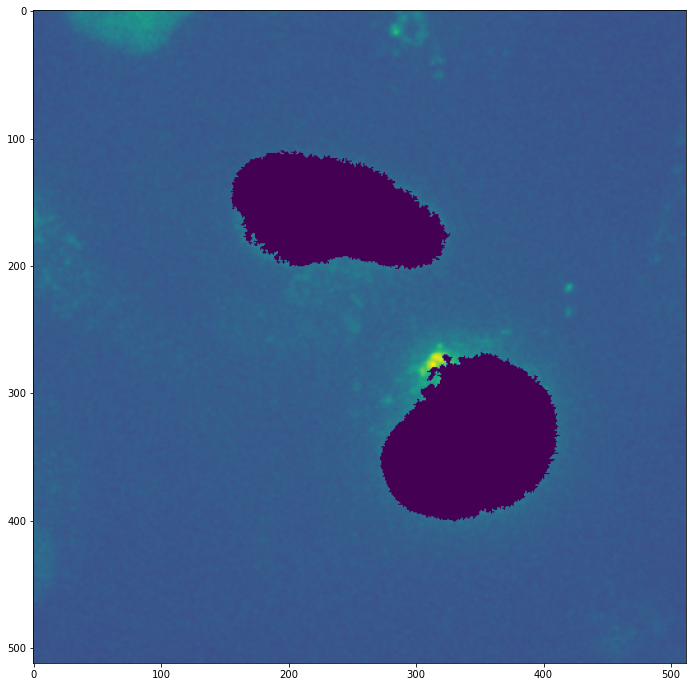

In [23]:
plt.imshow(mid_intensity_image1)
plt.show()

In [21]:
a = np.isin(Segment_tracker.labelled_stack[0,12,:,:], label_list)

In [38]:
Segment_tracker.labelled_stack[0,12,:,:] in label_list

C:\Users\joeshen\Anaconda3\envs\guv_pipeline\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [29]:
mid_intensity_image[a] = 0

## Store attributes in table

In [11]:
Segment_tracker = cell_tracking_quantify(track.segmented_object_image, track.seed_map_list, track.structure_img_smooth, cpla2_intensity_image)
Segment_tracker.intensity_stack_smooth()
Segment_tracker.mid_plane_extraction()
#Segment_tracker.watershed_segmentation_midplane()
#Segment_tracker.quantification_table_generate()
#Segment_tracker.tracking()
#Segment_tracker.crop_track()
#Segment_tracker.binding_normalize()

  0%|                                                   | 0/38 [00:00<?, ?it/s]


TypeError: 'numpy.uint8' object does not support item assignment

## Look at the tracking table
<br />

**x: x coordinate of centroid**
<br />

**y: y coordinate of centroid**
<br />

**z: z coordinate of centroid**
<br />

**frame: frame number in the time lapse**
<br />

**label: object ID generated by segmentation (It is not tracking ID)**
<br />

**area: Mid plane area in um^2**
<br />

**intensity ratio: The intensity of object(cell) rim / intensity of centroid**
<br />

**particle: tracking ID**
<br />

**normalized intensity ratio: ratio binding normalized to 1st frame**


In [16]:
# Have a look at the table
table= Segment_tracker.track_table


table.head()

,x,y,frame,label,area,intensity ratio,particle,normalized intensity ratio
Data,,,,,,,,
0,196.116646,99.950626,0,1,953.8622,0.912742,0,1.000000
1,196.256923,100.133223,1,1,962.6927,0.925274,0,1.013730
2,196.541102,100.607317,2,1,967.8228,0.981801,0,1.075661
3,196.803850,100.462105,3,1,969.8412,1.011507,0,1.108206
4,196.358437,100.734300,4,1,974.8872,1.040205,0,1.139648


## Visualize in Napari

In [10]:
# Visualize Final Result (3D)
viewer = napari.Viewer()
viewer.add_image(track.image, name = 'Raw Image', colormap='green',scale = [1,5,1,1])
viewer.add_image(track.structure_img_smooth, name = 'Smooth Image', colormap='green', scale = [1,5,1,1])
viewer.add_labels(track.segmented_object_image ,name='Segmented Object', scale = [1,5,1,1])
viewer.add_labels(track.bw_img,name='Segmented Object', scale = [1,5,1,1])
peaks = np.nonzero(track.seed_map_list)
viewer.add_points(np.array(peaks).T, name='peaks', size=5, face_color='red',scale=[1,5,1,1]);

In [23]:
# Visualize Final Result (2D)
viewer = napari.Viewer()
viewer.add_image(Segment_tracker.raw_image_stack_2D, colormap='green', name = 'Raw Image',blending='additive')
viewer.add_image(Segment_tracker.intensity_image_stack_2D,colormap='red',name = 'Intensity Image',blending='additive')
viewer.add_image(Segment_tracker.labelled_stack_2D, name = 'Labelled Image',blending='additive')
viewer.add_labels(Segment_tracker.segmented_image_2D_crop, name = 'Segmented Image',blending='additive')
viewer.add_image(Segment_tracker.distance_map_2D, name = 'Distance Map')
viewer.add_tracks(Segment_tracker.track_points, name='tracks', blending='additive')
viewer.add_image(Segment_tracker.seed_map_2D, name = 'Marker',blending='additive')
viewer.add_image(Segment_tracker.contour_image_crop,  name = 'Contour',blending='additive')

<Image layer 'Contour' at 0x3ee2db588>

In [25]:
a = np.array(peaks).T

## Plot Data (e.g. Volume, Protein binding)


In [22]:
# Plot volume for all objects (cells)
%matplotlib qt
import mplcursors
all_labels = Segment_tracker.track_table.particle.unique()

for label in all_labels:
   df_subset = Segment_tracker.track_table[Segment_tracker.track_table.particle == label]
   plt.plot(df_subset["frame"],df_subset["area"])

mplcursors.cursor(highlight=True,hover=True)

In [120]:
all_labels

array([0, 1], dtype=int64)

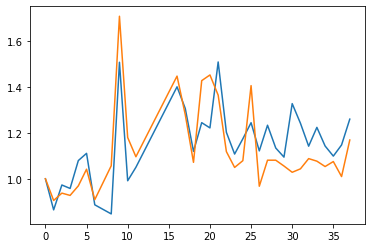

In [123]:
# Plot normalized intensity for all objects (cells)
all_labels = Segment_tracker.track_table.particle.unique()

for label in all_labels:
   df_subset = Segment_tracker.track_table[Segment_tracker.track_table.particle == label]
   plt.plot(df_subset["frame"],df_subset["normalized intensity ratio"])

In [ ]:
# Delete particular particles
label = [0]
Labelled_table = Labelled_table[Labelled_table.particle not in label]

## Save data and table

In [157]:
File_save_names = '.'.join(filename.split(".")[:-1])
analysis_save_name='{File_Name}_analysis'.format(File_Name = File_save_names)

In [71]:
# Save data to hdf5
seg_save_name='{File_Name}_segmentation_result.hdf5'.format(File_Name = File_save_names)

with h5py.File(seg_save_name, "w") as f:
      f.create_dataset('Countour Image', data = Segment_tracker.contour_image, compression = 'gzip')
      f.create_dataset('Segmented Object', data = Segment_tracker.segmented_image_2D, compression = 'gzip')
      f.create_dataset('Intensity Image', data = Segment_tracker.intensity_image_stack_2D, compression = 'gzip')
      f.create_dataset('Smooth Image', data = Segment_tracker.raw_image_stack_2D, compression = 'gzip')
      f.create_dataset('Seed Map', data = Segment_tracker.seed_map_2D, compression = 'gzip')


In [73]:
# Save table to csv
table_save_name = '{File_Name}_result.csv'.format(File_Name = File_save_names)

Labelled_table.to_csv(table_save_name,index=False)

In [14]:
%matplotlib qt